### Goal
This notebook focusses on POS tagging by encoding Yemba words as embedding vectors and to build a LSTM that predicts the part of speech of that Yemba word.
#### Source:https://towardsdatascience.com/lstm-based-african-language-classification-e4f644c0f29e

#### Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('english_yemba_dictionary.csv')
dataset.sample(5)

,Unnamed: 0,en,yb,yb_b,word_type,word_type_label
1287,2517,feed,lezek,"lizēk - ńzék, zékɛ́ (ńzék, zégé)",1,verb
2156,4170,music,azɔp,NaN,0,noun
1445,2801,give in marriage,lezɔ̄’,"lizɔ̄’ - ńzɔ́’, zɔ́’ɔ́",1,verb
1046,2012,disperse,leŋwaŋ,"liŋwaŋ - ŋ́ŋwaŋ, waŋā (ŋ́ŋwaŋ, ŋwaŋā)",1,verb
1424,2763,get,liwe,"lewɛ - ŋ́gwɛ, wiɛ̄ (ŋ́gwe, weē)",1,verb


#### Statistics

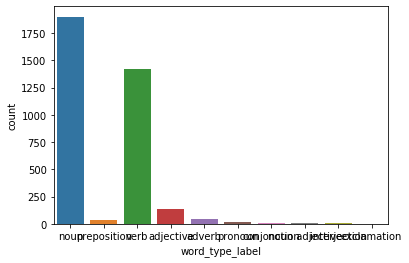

In [3]:
import seaborn as sns
sns.countplot(dataset['word_type_label'])

In [4]:
dataset.yb_utf8 = dataset.yb.str.encode('utf-8')

max_word_len = dataset.yb.str.len().max()
max_word_len_utf8 = dataset.yb_utf8.str.len().max()
nb_labels = len(dataset.word_type.unique())
nb_words = dataset.shape[0]
print("Number of words: ", nb_words)
print("Number of labels: ", nb_labels)
print("Max word length: {} characters and {} bytes".format(max_word_len, max_word_len_utf8))

Number of words:  3587
Number of labels:  10
Max word length: 26 characters and 38 bytes


C:\Users\Simmi\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


#### Preprocessing

In [5]:
# Create letter to token dictionary
chars = sorted(list(set(' '.join(dataset.yb))))
letter2idx = dict((c, i+1) for i, c in enumerate(chars))
print(letter2idx)
# Create token to letter dictionary
idx2letter = dict((i, c) for c, i in letter2idx.items())
print(idx2letter)
vocabulary_size = len(letter2idx)+1
print("Vocabulary size: ", vocabulary_size)

{' ': 1, '(': 2, ')': 3, '-': 4, '.': 5, '/': 6, 'a': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'h': 14, 'i': 15, 'j': 16, 'k': 17, 'l': 18, 'm': 19, 'n': 20, 'o': 21, 'p': 22, 'r': 23, 's': 24, 't': 25, 'u': 26, 'v': 27, 'w': 28, 'y': 29, 'z': 30, '\xa0': 31, 'á': 32, 'é': 33, 'í': 34, 'ó': 35, 'ù': 36, 'ú': 37, 'ń': 38, 'ŋ': 39, 'ǝ': 40, 'ɔ': 41, 'ɛ': 42, 'ʉ': 43, '́': 44, '̄': 45, '́': 46, '’': 47}
{1: ' ', 2: '(', 3: ')', 4: '-', 5: '.', 6: '/', 7: 'a', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'h', 15: 'i', 16: 'j', 17: 'k', 18: 'l', 19: 'm', 20: 'n', 21: 'o', 22: 'p', 23: 'r', 24: 's', 25: 't', 26: 'u', 27: 'v', 28: 'w', 29: 'y', 30: 'z', 31: '\xa0', 32: 'á', 33: 'é', 34: 'í', 35: 'ó', 36: 'ù', 37: 'ú', 38: 'ń', 39: 'ŋ', 40: 'ǝ', 41: 'ɔ', 42: 'ɛ', 43: 'ʉ', 44: '́', 45: '̄', 46: '́', 47: '’'}
Vocabulary size:  48


#### Tokenizing

In [6]:
X = []
Y = []
max_len = 0
for i, r in dataset.iterrows():
    word_vector = [letter2idx[c] for c in set(r.yb)]
    label = r.word_type
    if len(word_vector)>max_len:
        max_len = len(word_vector)
    X.append(word_vector)
    Y.append(label)

In [7]:
len(X), len(Y), max_len

(3587, 3587, 15)

#### Padding

In [8]:
import tensorflow
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

X = sequence.pad_sequences(X, maxlen=max_len)
Y = to_categorical(Y)
X.shape, Y.shape

((3587, 15), (3587, 12))

In [9]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### Splitting into training and test set

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=123)
print("Training with {} words, testing with {} words".format(X_train.shape[0], X_test.shape[0]))

Training with 2869 words, testing with 718 words


#### Building the model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Flatten
from keras.layers.embeddings import Embedding

# Building a 1-layer LSTM with 100 cells with embeddings
embedding_dim = 8
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, embedding_dim, input_length=max_len))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(Y.shape[1], activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 45,196
Trainable params: 45,196
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [12]:
# Training the network
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
history_lstm = model_lstm.fit(X_train, Y_train, epochs=50, batch_size=32, 
                              validation_data=(X_test, Y_test), callbacks=[early_stopping])
scores_lstm = model_lstm.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_lstm[1]*100))

C:\Users\Simmi\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2869 samples, validate on 718 samples
Epoch 1/50
2869/2869 [==============================] - 1s 519us/step - loss: 0.2474 - accuracy: 0.9153 - val_loss: 0.1474 - val_accuracy: 0.9204
Epoch 2/50
 576/2869 [=====>........................] - ETA: 0s - loss: 0.1471 - accuracy: 0.9253

C:\Users\Simmi\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2869/2869 [==============================] - 1s 306us/step - loss: 0.1448 - accuracy: 0.9208 - val_loss: 0.1470 - val_accuracy: 0.9204
Epoch 3/50
2869/2869 [==============================] - 1s 295us/step - loss: 0.1436 - accuracy: 0.9232 - val_loss: 0.1449 - val_accuracy: 0.9295
Epoch 4/50
2869/2869 [==============================] - 1s 275us/step - loss: 0.1395 - accuracy: 0.9290 - val_loss: 0.1404 - val_accuracy: 0.9263
Epoch 5/50
2869/2869 [==============================] - 1s 277us/step - loss: 0.1305 - accuracy: 0.9396 - val_loss: 0.1304 - val_accuracy: 0.9415
Epoch 6/50
2869/2869 [==============================] - 1s 283us/step - loss: 0.1196 - accuracy: 0.9491 - val_loss: 0.1126 - val_accuracy: 0.9586
Epoch 7/50
2869/2869 [==============================] - 1s 278us/step - loss: 0.0998 - accuracy: 0.9644 - val_loss: 0.1012 - val_accuracy: 0.9602
Epoch 8/50
2869/2869 [==============================] - 1s 279us/step - loss: 0.0889 - accuracy: 0.9697 - val_loss: 0.0945 - val_accura

#### Visualization of results

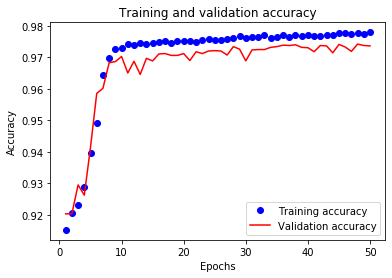

In [13]:
# Displaying training performance
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Testing LSTM for random words

In [14]:
# Prediction on random words
nb=100
words = []
en = []
word_vectors = []
true_labels =[]
predicted_labels=[]

for word_type_label in ['noun', 'verb']:
    words_df = dataset[dataset.word_type_label==word_type_label]
    if words_df.shape[0] > nb:
        words_df = words_df.sample(n=nb)
        
    for i, r in words_df.iterrows():
        words.append(r.yb)
        en.append(r.en)
        word_vector = [letter2idx[c] for c in set(r.yb)]
        word_vectors.append(word_vector)
        true_labels.append(word_type_label)
        word_vector = sequence.pad_sequences([word_vector], maxlen=max_len)
        predicted_label = np.argmax(model_lstm.predict(word_vector), axis=1)[0]
        predicted_labels.append('noun' if predicted_label==0 else 'verb')

df_results = pd.DataFrame({'en': en,
                           'yemba': words,
                           'true label': true_labels, 
                           'predicted label': predicted_labels})                        

#### Evaluation of results

                   en               yemba true label predicted label
0             buttock              lemwɛt       noun            verb
2           happiness               lepɔŋ       noun            verb
5            holy day            ale’ńzhɛ       noun            verb
6               glory                lipe       noun            verb
20            despair              atabli       noun            verb
27               trap               lekhu       noun            verb
32             middle  tsetsɛlɛ /tsetsɛtɛ       noun            verb
37        sort of mat         akwelékwele       noun            verb
40   burial (funeral)             ligwhʉ̄       noun            verb
42             tunnel              lisōŋ       noun            verb
44               base              letseŋ       noun            verb
62               twin              lefāk       noun            verb
63               bank              ligēŋ       noun            verb
66        compartment             

0.895

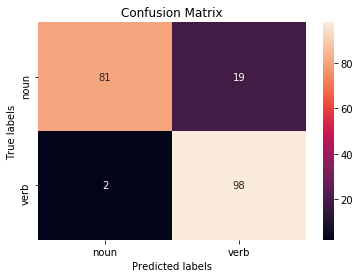

In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(true_labels, predicted_labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['noun', 'verb']); 
ax.yaxis.set_ticklabels(['noun', 'verb']);

# False positives and false negatives
print(df_results[df_results['true label']!=df_results['predicted label']])

accuracy_score(true_labels,predicted_labels)